In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob

import pandas as pd
import numpy as np

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Dropbox (LWA)/Flopy Training/')



In [3]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)

# other functions
py_dir = join(doc_dir,'GitHub/gw_training/utilities')
add_path(py_dir)

from mf_utility import get_layer_from_elev
from map_cln import gdf_bnds, plt_cln

In [4]:
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')
# if flopy exists on the computer elsewhere and not under GitHub it will be found as well
import flopy 

# Model Set up
<img src="img/exercise1_conceptual_model_dimensions.png" width="400" height="500"/>

In [5]:
loadpth = 'C:/WRDAPP/GWFlowModel/training'
model_ws = join(loadpth, 'exercise_1')
os.makedirs(model_ws, exist_ok=True)

In [6]:
## define grid discretization ##
## layer elevations can be defined later
nrow = 18
ncol = 18
delr = 1000
delc = 1000
rotation = 0

# the vertical confining bed is not considered a layer as it will be applied below a given layer
nlay = 2


In [7]:
## define time discretization ##

nper = 1

# Each period has a length of one because the timestep is one month, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# stress period unit is days so need to increase stress period
# perlen[1:] = dates.days_in_month
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Bimonthly timesteps
nstp = np.ones(nper).astype(int)

In [8]:
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
                          version = 'mf2005', model_ws=model_ws)

#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(model=m,
                               nrow=nrow, ncol=ncol, nlay=nlay, 
                               delr=delr, delc=delc,
                               lenuni = 2, itmuni = 1,
#                                rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
#                               start_datetime = strt_date
                              )


In [56]:
# flopy.modflow.ModflowDis?

While some objects by default produce copies, it is a good practice to ensure you are not linking arrays by using the np.copy function or for pandas pd.DataFrame.copy()

In [9]:
## define layer bottom elevations ##
# create copies of arrays with default values
top = np.copy(m.dis.top.array)
botm = np.copy(m.dis.botm.array)
# assign model top elevations
top[:,:] = 100
# assign layer bottom elevations
lay_elev = np.array([50, 0])
for k in np.arange(0,nlay):
    botm[k,:,:] = lay_elev[k]
    
# redefine the values in the floy DIS object
m.dis.top = top
m.dis.botm = botm



In [10]:
# define middle layer as a quasi-3d confining bed
# flopy says the array defines whether a layer has a confining bed below it,
# not sure if that means the layer below or how properties are then defined
laycbd = np.copy(dis.laycbd.array)
laycbd[0] = 1
dis.laybcd = laycbd

## Basic Package (BAS6)

In [11]:
# assume all cells are initially active
ibound = np.ones(m.dis.botm.shape)
# have starting heads at ground surface so every cell is active
strt = m.dis.top

In [12]:
# define the basic package
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

## Layer Property Flow Package (LPF)

In [57]:
# load hydraulic parameter data
param = pd.read_excel('data/exercise1_hydraulic_parameters.xlsx', sheet_name='geologic', comment='#')
param.to_csv(join(model_ws, 'exercise1_hydraulic_parameters_ucode.csv'))

In [58]:
# allocate arrays for hydraulic conductivity (HK), vertical HK, specific storage (Ss), specific yield (Sy)
hk = np.zeros(m.dis.botm.shape)
vka = np.zeros(m.dis.botm.shape)

# define vertical confining bed conductivity
vkcb = np.zeros(m.dis.botm.shape)

In [59]:
for k in np.arange(0,nlay):
    param_k = param[param.layer==k+1]
    hk[k] = param_k.loc[param_k.GroupName=='hk','StartValue']
    vka[k] = param_k.loc[param_k.GroupName=='vani','StartValue']
    vkcb[k] = param_k.loc[param_k.GroupName=='vkcb','StartValue']


In [16]:

# VKA is defined where: 0 is vertical hydraulic conductivity, and 1 is vertical anisotropy
layvka = 1
# chani is defined where: 0 means HANI defines HANI and >0  means CHANI defines HANI for entire layers
chani = 0
# hani is the ratio of horizontal anisotropy (along columns vs rows (x vs. y))
hani = 1
# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
laytyp = np.zeros(m.dis.nlay)
laywet = laytyp[:]
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
# laywet = 1 means layers can be rewetted.
#ipakcb = 53 means cell-by-cell budget is saved because it is non zero (default is 53)
lpf = flopy.modflow.ModflowLpf(model = m, 
                               hk =hk, chani = chani, hani = hani,
                               layvka = layvka, vka = vka, 
                               vkcb = vkcb,
                               laytyp=laytyp, laywet = laywet, ipakcb=53,
                              )

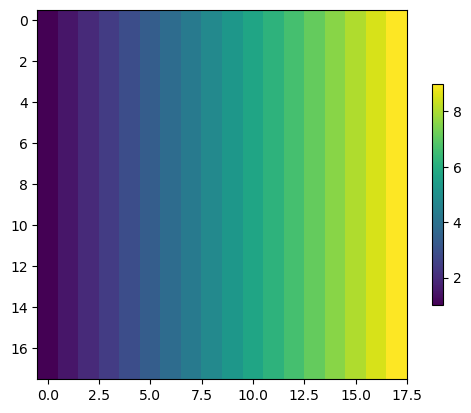

In [17]:
# multipliers are not directly defineable within flopy, but
# it is easily applicable with an array to mulitply the value
mult_1d = np.linspace(1, 9, ncol)
# the array must be reshaped to have a 2nd axis to then repeat along that axis
mult_2d = np.repeat(np.reshape(mult_1d, (1, ncol)), nrow, axis=0)
plt.imshow(mult_2d)
plt.colorbar(shrink=0.6)

In [18]:
hk.shape

(2, 18, 18)

In [19]:
# we can now scale the HK in layer 2 by the multiplier array
hk_mult = np.copy(hk)
hk_mult[1] = hk[1] * mult_2d

# this can then be redefined in the LPF package
lpf.hk = hk_mult

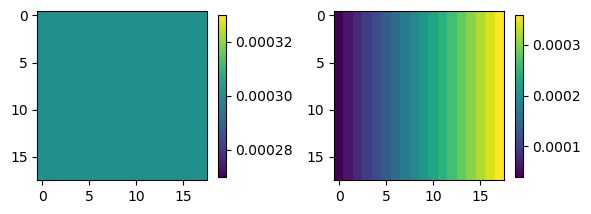

In [20]:
# we can check the final hydrualic conductivity with the same plotting method
fig,ax = plt.subplots(1,nlay ,figsize=(6,3))
for k in np.arange(0,nlay):
    im = ax[k].imshow(lpf.hk.array[k])
    plt.colorbar(im, shrink=0.6)
fig.tight_layout()

# Boundary Conditions
<img src="img/exercise1_conceptual_model.png" width="400" height="500"/>

Boudary Conditions (BC) to implement:
- GHB for the leaky reservoir
- RIV for the river
- RCH for the precipitation

## River Package (RIV)

<img src="img/river_BC_schematic.png" width="400" height="500"/>

In [21]:
# intialize the river package
riv = flopy.modflow.ModflowRiv(model=m, ipakcb=53)

In [22]:
# the river package is connected to layer 1 in all of the rows of the first column
# we must provide input in 0-based (python) format
riv_row = np.arange(0,nrow)
riv_col = np.zeros(nrow)
riv_layer = np.zeros(nrow)


In [23]:
# the key input information for the river package is
# layer, row, column (k, i, j), stage, conductance (cond) and river bottom (rbot)
riv_df = pd.DataFrame(riv.stress_period_data[0]) # create a blank dataframe with columns
# assign values
riv_df['k'] = riv_layer.astype(int)
riv_df['i'] = riv_row.astype(int)
riv_df['j'] = riv_col.astype(int)



In [24]:
# the riverbed conductance is calculated with the dimensions of the model and assigned K value
K = 1.2E-3 # vertical conductivity of the river bed (m/s)
K = param.loc[param.ParamName=='k_rb','StartValue'].values[0]
L = 1000 # length of the river in each cell (m)
W = 10 # river width (m)
M = 10 # river bed thickness (m)
# calculate the conductance of the river (values that are not affected by internal head calculations)
C = K*L*W/M # conductance (m^2/s)

# river conductance is the value calculated before
riv_df['cond'] = C

# river stage is assumed to be at the model top, although it can be greater than this
riv_df['stage'] = top[riv_df.i, riv_df.j] 
# the river bottom is the river top minus the river thickness
riv_df['rbot'] = top[riv_df.i, riv_df.j] - M


In [25]:
# flopy reads in the river data as a numpy array for each stress period defined as a dictionary
riv_dict = {}
# stress period 0 is defined with the river array
# if no new data is supplied it is assumed the river values remain constant
riv_dict[0] = np.array(riv_df)

# assign the stress_period data to the flopy RIV object
riv.stress_period_data = riv_dict

## General Head Boundary (GHB)
This represents the leaky reservoir.

In [26]:
# intialize the river package
ghb = flopy.modflow.ModflowGhb(model=m, ipakcb=53)

In [27]:
# the GHB package is connected to layer 1 and 2 in all of the rows of the last column
# we must provide input in 0-based (python) format
ghb_row = np.arange(0,nrow)
ghb_col = np.full(nrow, ncol-1)
ghb_layer = np.zeros(nrow)



In [28]:
# the key input information for the river package is
# layer, row, column (k, i, j), stage, conductance (cond) and river bottom (rbot)
ghb_df = pd.DataFrame(ghb.stress_period_data[0]) # create a blank dataframe with columns
# assign values
ghb_df['k'] = ghb_layer.astype(int)
ghb_df['i'] = ghb_row.astype(int)
ghb_df['j'] = ghb_col.astype(int)

# currently the GHB is only assigned to layer 1 we can copy the dataframe
# and make a second with the layer specified as 2 and append it to identify all layers
ghb_2 = ghb_df.copy().assign(k=1)
ghb_df = pd.concat((ghb_df, ghb_2))

# ghb boundary head is set as the reservoir water surface elevation
ghb_df['bhead'] = 350

In [29]:
# the GHB conductance is calculated with the dimensions of the model and assigned K value
# K = 2E-9 # vertical conductivity of the low permeability granite (m/s)
K = param.loc[param.ParamName=='hk_hillside','StartValue'].values[0]
L = 1000 # length of the ghb in each cell (m)
W = 50 # vertical thickness for each layer (m)
M = 1000 # low permeability granite thickness (m)
# calculate the conductance of the leaky reservoir (values that are not affected by internal head calculations)
C = K*L*W/M # conductance (m^2/s)
# # ghb conductance is the value calculated before
ghb_df['cond'] = C

print('GHB cond: %.2E $m^2/s$' %C)

GHB cond: 1.00E-07 $m^2/s$


In [30]:
# flopy reads in the ghb data as a numpy array for each stress period defined as a dictionary
ghb_dict = {}
# stress period 0 is defined with the river array
# if no new data is supplied it is assumed the ghb values remain constant
ghb_dict[0] = np.array(ghb_df)

# assign the stress_period data to the flopy GHB object
ghb.stress_period_data = ghb_dict

## Recharge Package (RCH)

In [31]:
# intialize the recharge package
# specify recharge goes to the topmost active layer (nrchop = 3)
# alternatives are: 1 - recharge top top layer only, 2 - recharge to layer specified in irch
# value in modelmuse was left as 1
rch = flopy.modflow.ModflowRch(model=m, nrchop = 1, ipakcb=53)

In [32]:
# recharge input data is specified with arrays of vertical recharge rates (L/T)
# with an array specified for each stress period
# if a new stress period is not provided the data from the previous is reused
rch_dict = {}

rch_arr = np.zeros((nrow,ncol))
# define the domain with recharge rates for the left and right sides
split_col = int(ncol/2)
# recharge rates are presented in cm/yr and must be converted to m/s
cmyr2ms = 1/(100*365*86400)
rch_arr[:, :split_col] = 63.072*cmyr2ms
rch_arr[:, split_col:] = 31.536*cmyr2ms

# assign stress period 1
rch_dict[0] = rch_arr
# assign to RCH object
rch.rech = rch_dict

# HOB
The pre-processed HOB from the Hill examples is relatively simple. If only used for UCODE then the input steps aren't necessary to teach.

In [33]:
hob = flopy.modflow.ModflowHob.load('data/MF.hob', model=m)

## Output Control (OC)

In [34]:
# make a list of the combinations of stress periods and time steps
kstpkper = []
kperkstp = []
for n,stps in enumerate(nstp):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))
    kperkstp += list(zip(np.full(stps,n),np.arange(0,stps)))



In [35]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# create a default dictionary with output saved for all stress periods and steps
oc_dict = dict.fromkeys(kperkstp, ['save head','save budget', 'print budget'])

oc = flopy.modflow.ModflowOc(model = m, stress_period_data = oc_dict, compact = True)

## Solver packages
Commonly used solvers include the SIP and PCG.
For more complext problems the PCGN and NWT solver may be applicable.


In [36]:
# mixter: outer iterations, iter1 : inner iterations
pcg = flopy.modflow.ModflowPcg(m, mxiter = 100, iter1=60, rclose=1e-04, hclose=1e-06, 
#                                 ipunit=28
                               )

# iter_mo max outer iters, ter_mi = max inner iters, close_r residual criterion for stopping iteration
# close_h is alternate criterion for nonlinear problem, and is head closure which should be smaller than residual closer

# pcgn = flopy.modflow.ModflowPcgn(m, iter_mo = 100, iter_mi=60, close_r=1e-01, close_h=1e-02, ipunit=28)


# Run the model

In [37]:
# flopy has built in checks
m.check()


MF MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Variable NRCHOP set to value other than 3

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    RIV package: stage below cell bottom
   

In [38]:
# write the model input
m.write_input()

In [39]:
# run the model
success, buff = m.run_model()

FloPy is using the following executable to run the model: C:\WRDAPP\MF2005.1_12\bin\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: MF.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/09/18  8:31:22

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/09/18  8:31:22
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation


# Post-process

## UCODE

In [40]:
from ucode_input import get_magnitude, make_gel_p_long, prep_gel_pdata, write_pdata, write_hob_jif_dat

In [41]:
param_ucode = param.drop(columns=['layer','Units']).copy()
param_jtf = param.copy()
param_jtf['StartValue'] = '@'+param_jtf.ParamName.str.ljust(20)+'@'
with open(join(model_ws, 'exercise_1_hydraulic_parameters_ucode.csv.jtf'), 'w',newline='') as f:
    f.write('jtf @\n')
    param_jtf.to_csv(f,index=True, mode="a")
    

In [42]:
pdata = prep_gel_pdata(param_ucode)
write_pdata(pdata, model_ws, 'MF_ucode.pdata')



Wrote pdata file


In [43]:
# load hobout to make instruction file
hobout = pd.read_csv(join(model_ws, 'MF.hob.out'), delimiter=r'\s+')


In [44]:
# write instruction file
write_hob_jif_dat(model_ws, hobout, statflag=False)

## Plot heads

In [45]:
# load the binary head output
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# we can extract the stress periods and times of output
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()




C:\Users\andrewc\AppData\Local\Temp\ipykernel_23340\39303235.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


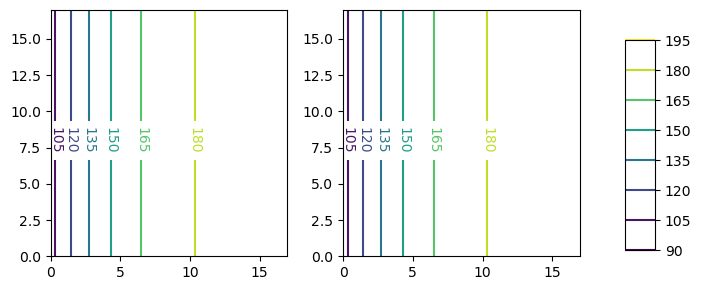

In [46]:
head = hdobj.get_data(kstpkper=(0,0))

fig,ax=plt.subplots(1,nlay, figsize=(6,3))
vmin = head.min()
vmax = head.max()
for k in np.arange(0,nlay):
#     im = ax[k].imshow(head[k])
    im = ax[k].contour(head[k], vmin=vmin, vmax=vmax)
    ax[k].clabel(im, im.levels, inline=True, fontsize=10)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, shrink=0.7)
fig.tight_layout()

## Plot water budget

In [47]:
cbc = model_ws+'/MF.cbc'


In [48]:
def zone_clean(cbc,zon, kstpkper):
    zb = flopy.utils.ZoneBudget(cbc, zon, kstpkper)
    zb_df = zb.get_dataframes()
    # ungroup by timestep
    zb_df = zb_df.reset_index()
    names = zb_df.name.unique()
    zb_df = zb_df.pivot(index = 'totim', columns = 'name',values = 'ZONE_1')
    
    # columns to make negative
    to_cols = zb_df.columns[zb_df.columns.str.contains('TO_')]
    # multiply by -1 to have pulled out of water balance on plot
    zb_df.loc[:, to_cols] *= -1
    # correct for storage change
    # to storage is gw increase (positive)
    stor_cols = zb_df.columns[zb_df.columns.str.contains('STORAGE')]
    if len(stor_cols)>0:
        zb_df['dSTORAGE'] = (zb_df.TO_STORAGE + zb_df.FROM_STORAGE) * -1
        zb_df = zb_df.drop(columns=stor_cols)
    zb_df = zb_df.reset_index()
    return(zb_df)

In [49]:
zb_df = zone_clean(cbc, np.ones(m.dis.botm.shape, dtype=int), (0,0))

C:\Users\andrewc\Documents/GitHub/flopy\flopy\utils\binaryfile.py:1135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\Users\andrewc\Documents/GitHub/flopy\flopy\utils\binaryfile.py:1135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\Users\andrewc\Documents/GitHub/flopy\flopy\utils\binaryfile.py:1135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(header2["imeth"]) == 6:
C:\Users\andrewc\Docum

In [50]:
mod_cols = zb_df.columns[zb_df.columns.str.contains('TO_|FROM_')].values
mod_cols = mod_cols[(np.abs(zb_df[mod_cols])>0).sum(axis=0).astype(bool)]


In [51]:
util_dir = join(doc_dir,'GitHub','gw_training','utilities')
fn = join(util_dir,'mf_wb_color_dict.xlsx')
zon_color_dict = pd.read_excel(fn, index_col='flux',comment='#', sheet_name='mf_wb_color_dict').color.to_dict()
zon_name_dict = pd.read_excel(fn,index_col='flux',comment='#', sheet_name='mf_wb_color_dict').name.to_dict()

Text(0, 0.5, 'Volumetric Flux ($m^3/s$)')

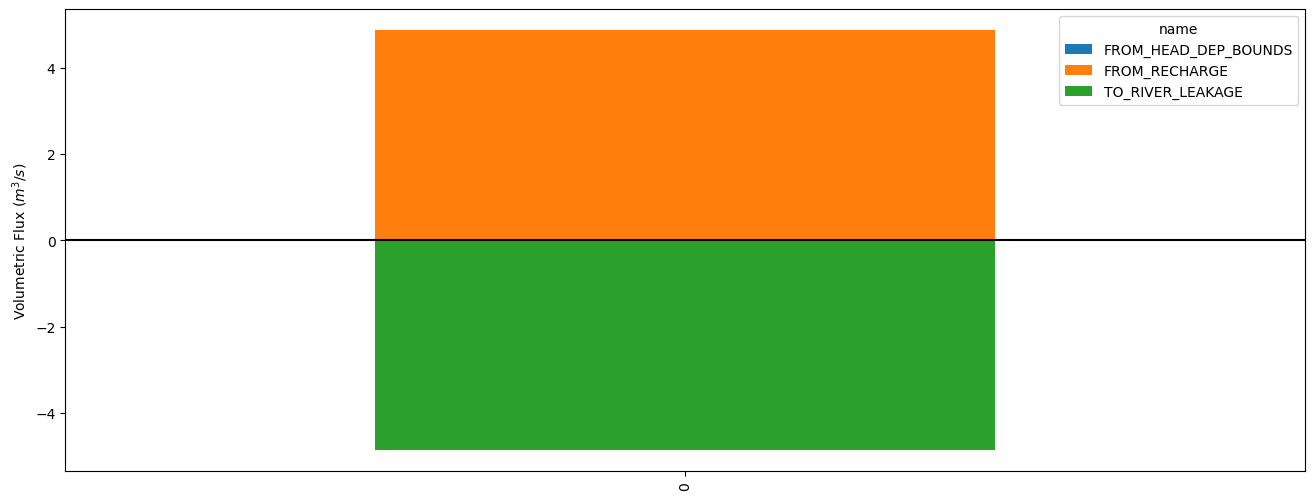

In [54]:
# convert m3 to AF
# zb_mod_all_AF = (all_mon*(1/0.3048**3)*(1/43560))

fig, ax = plt.subplots(figsize=(16,6))
# bar plot xticks are plotted as values
zb_df.plot(y=mod_cols,
           kind='bar',ax=ax, stacked = True,
#                color=[zon_color_dict[x] for x in mod_cols], 
#            label = [zon_name_dict[x] for x in mod_cols]
          )
ax.hlines(y=0, xmin = -100, xmax = 100, color = 'black')
plt.ylabel('Volumetric Flux ($m^3/s$)')
# lines are continuous xticks, either force datetime into strings or reuse previous xticks
# ax.plot(zb_mod_all_AF.index.astype(str), zb_mod_all_AF.dSTORAGE, color='black')
